<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [5]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [6]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip   
else:
    print("El dataset ya se encuentra descargado")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 2026k  100 2026k    0     0  1214k      0  0:00:01  0:00:01 --:--:-- 1217k


In [7]:
# Posibles bandas
os.listdir("./songs_dataset/")

['adele.txt',
 'al-green.txt',
 'alicia-keys.txt',
 'amy-winehouse.txt',
 'beatles.txt',
 'bieber.txt',
 'bjork.txt',
 'blink-182.txt',
 'bob-dylan.txt',
 'bob-marley.txt',
 'britney-spears.txt',
 'bruce-springsteen.txt',
 'bruno-mars.txt',
 'cake.txt',
 'dickinson.txt',
 'disney.txt',
 'dj-khaled.txt',
 'dolly-parton.txt',
 'dr-seuss.txt',
 'drake.txt',
 'eminem.txt',
 'janisjoplin.txt',
 'jimi-hendrix.txt',
 'johnny-cash.txt',
 'joni-mitchell.txt',
 'kanye-west.txt',
 'kanye.txt',
 'Kanye_West.txt',
 'lady-gaga.txt',
 'leonard-cohen.txt',
 'lil-wayne.txt',
 'Lil_Wayne.txt',
 'lin-manuel-miranda.txt',
 'lorde.txt',
 'ludacris.txt',
 'michael-jackson.txt',
 'missy-elliott.txt',
 'nickelback.txt',
 'nicki-minaj.txt',
 'nirvana.txt',
 'notorious-big.txt',
 'notorious_big.txt',
 'nursery_rhymes.txt',
 'patti-smith.txt',
 'paul-simon.txt',
 'prince.txt',
 'r-kelly.txt',
 'radiohead.txt',
 'rihanna.txt']

In [8]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)
df.head()

D:\Users\juanp_schamun\AppData\Local\Temp\ipykernel_2684\3849064916.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)


,0
0,"Yesterday, all my troubles seemed so far away"
1,Now it looks as though they're here to stay
2,"Oh, I believe in yesterday Suddenly, I'm not h..."
3,There's a shadow hanging over me.
4,"Oh, yesterday came suddenly Why she had to go ..."


In [9]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1846


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [10]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [11]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'Yesterday, all my troubles seemed so far away'

In [12]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['yesterday', 'all', 'my', 'troubles', 'seemed', 'so', 'far', 'away']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [13]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [14]:
# Demos un vistazo
sentence_tokens[:2]

[['yesterday', 'all', 'my', 'troubles', 'seemed', 'so', 'far', 'away'],
 ['now', 'it', 'looks', 'as', 'though', "they're", 'here', 'to', 'stay']]

In [17]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)+1):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [18]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['yesterday', 'all', 'my', 'troubles'],
 ['all', 'my', 'troubles', 'seemed'],
 ['my', 'troubles', 'seemed', 'so'],
 ['troubles', 'seemed', 'so', 'far'],
 ['seemed', 'so', 'far', 'away']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [19]:
tok = Tokenizer() 

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [20]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[7, 5, 3, 1], [5, 3, 1, 2], [3, 1, 2, 4], [1, 2, 4, 6], [2, 4, 6, 8]]

In [21]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

5


In [22]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

8


In [23]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'troubles': 1, 'seemed': 2, 'my': 3, 'so': 4, 'all': 5, 'far': 6, 'yesterday': 7, 'away': 8}


In [24]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'troubles': 4, 'yesterday': 1, 'all': 2, 'my': 3, 'seemed': 4, 'so': 3, 'far': 2, 'away': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [25]:
# Vistazo a las primeras filas
df.loc[:15,0]

0         Yesterday, all my troubles seemed so far away
1           Now it looks as though they're here to stay
2     Oh, I believe in yesterday Suddenly, I'm not h...
3                     There's a shadow hanging over me.
4     Oh, yesterday came suddenly Why she had to go ...
5     I said something wrong, now I long for yesterd...
6                       Now I need a place to hide away
7     Oh, I believe in yesterday Why she had to go I...
8     I said something wrong, now I long for yesterd...
9                       Now I need a place to hide away
10                           Oh, I believe in yesterday
11    Mm mm mm mm mm mm mm When I find myself in tim...
12                  Speaking words of wisdom, let it be
13    And in my hour of darkness she is standing rig...
14                  Speaking words of wisdom, let it be
15           Let it be, let it be, let it be, let it be
Name: 0, dtype: object

In [26]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Yesterday, all my troubles seemed so far away Now it looks as though they\'re here to stay Oh, I believe in yesterday Suddenly, I\'m not half the man I used to be There\'s a shadow hanging over me. Oh, yesterday came suddenly Why she had to go I don\'t know she wouldn\'t say I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play Now I need a place to hide away Oh, I believe in yesterday Why she had to go I don\'t know she wouldn\'t say I said something wrong, now I long for yesterday Yesterday, love was such an easy game to play Now I need a place to hide away Oh, I believe in yesterday Mm mm mm mm mm mm mm When I find myself in times of trouble, Mother Mary comes to me Speaking words of wisdom, let it be And in my hour of darkness she is standing right in front of me Speaking words of wisdom, let it be Let it be, let it be, let it be, let it be Whisper words of wisdom, let it be And when the broken hearted people living in the world agree There

In [27]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['yesterday',
 'all',
 'my',
 'troubles',
 'seemed',
 'so',
 'far',
 'away',
 'now',
 'it',
 'looks',
 'as',
 'though',
 "they're",
 'here',
 'to',
 'stay',
 'oh',
 'i',
 'believe']

In [28]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 14387


In [29]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)+1):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [30]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['yesterday', 'all', 'my', 'troubles'],
 ['all', 'my', 'troubles', 'seemed'],
 ['my', 'troubles', 'seemed', 'so'],
 ['troubles', 'seemed', 'so', 'far'],
 ['seemed', 'so', 'far', 'away'],
 ['so', 'far', 'away', 'now'],
 ['far', 'away', 'now', 'it'],
 ['away', 'now', 'it', 'looks'],
 ['now', 'it', 'looks', 'as'],
 ['it', 'looks', 'as', 'though'],
 ['looks', 'as', 'though', "they're"],
 ['as', 'though', "they're", 'here'],
 ['though', "they're", 'here', 'to'],
 ["they're", 'here', 'to', 'stay'],
 ['here', 'to', 'stay', 'oh'],
 ['to', 'stay', 'oh', 'i'],
 ['stay', 'oh', 'i', 'believe'],
 ['oh', 'i', 'believe', 'in'],
 ['i', 'believe', 'in', 'yesterday'],
 ['believe', 'in', 'yesterday', 'suddenly']]

In [31]:
# Proceso de tokenización
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[216, 10, 12, 907],
 [10, 12, 907, 908],
 [12, 907, 908, 42],
 [907, 908, 42, 909],
 [908, 42, 909, 121],
 [42, 909, 121, 22],
 [909, 121, 22, 13],
 [121, 22, 13, 638],
 [22, 13, 638, 91],
 [13, 638, 91, 217],
 [638, 91, 217, 349],
 [91, 217, 349, 79],
 [217, 349, 79, 4],
 [349, 79, 4, 314],
 [79, 4, 314, 23],
 [4, 314, 23, 2],
 [314, 23, 2, 160],
 [23, 2, 160, 9],
 [2, 160, 9, 216],
 [160, 9, 216, 520]]

In [32]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 14384


### 3 - Input y target

In [33]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [34]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [35]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [36]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(14384, 3)
(14384,)


In [37]:
# Palabras del vocabulario
tok.index_word

{1: 'you',
 2: 'i',
 3: 'the',
 4: 'to',
 5: 'and',
 6: 'love',
 7: 'a',
 8: 'me',
 9: 'in',
 10: 'all',
 11: 'nah',
 12: 'my',
 13: 'it',
 14: 'know',
 15: 'be',
 16: 'that',
 17: 'of',
 18: 'on',
 19: 'she',
 20: 'is',
 21: 'say',
 22: 'now',
 23: 'oh',
 24: 'yeah',
 25: 'your',
 26: 'get',
 27: "don't",
 28: 'back',
 29: 'let',
 30: 'with',
 31: 'her',
 32: 'can',
 33: "it's",
 34: 'do',
 35: "i'm",
 36: 'when',
 37: 'come',
 38: 'will',
 39: 'he',
 40: 'but',
 41: 'for',
 42: 'so',
 43: 'need',
 44: 'there',
 45: 'like',
 46: 'no',
 47: 'together',
 48: "i'll",
 49: 'see',
 50: 'was',
 51: 'never',
 52: 'we',
 53: 'down',
 54: 'way',
 55: 'if',
 56: 'want',
 57: 'out',
 58: 'hey',
 59: 'one',
 60: 'got',
 61: 'go',
 62: 'well',
 63: "can't",
 64: 'girl',
 65: 'good',
 66: 'his',
 67: 'sun',
 68: 'they',
 69: 'home',
 70: 'hello',
 71: 'day',
 72: 'are',
 73: 'ah',
 74: 'right',
 75: 'little',
 76: 'at',
 77: 'from',
 78: 'man',
 79: 'here',
 80: 'help',
 81: 'gonna',
 82: 'have',
 

In [38]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1628

In [40]:
# Transformar los datos a oneHotEncoding
# Esto va a dar error a propisito
# y_data = to_categorical(y_data_int, num_classes=vocab_size)

In [41]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [42]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(14384, 1628)

### 4 - Entrenar el modelo

In [43]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [44]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

1628

In [46]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 5)              8145      
                                                                 
 lstm_2 (LSTM)               (None, 3, 64)             17920     
                                                                 
 dropout_1 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1628)              53724     
                                                                 
Total params: 114893 (448.80 KB)
Trainable params: 114

In [47]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
360/360 [==============================] - 9s 10ms/step - loss: 6.1528 - accuracy: 0.0435 - val_loss: 6.5178 - val_accuracy: 0.0400
Epoch 2/50
360/360 [==============================] - 2s 6ms/step - loss: 5.7475 - accuracy: 0.0501 - val_loss: 6.6641 - val_accuracy: 0.0400
Epoch 3/50
360/360 [==============================] - 2s 6ms/step - loss: 5.6993 - accuracy: 0.0501 - val_loss: 6.7533 - val_accuracy: 0.0400
Epoch 4/50
360/360 [==============================] - 2s 6ms/step - loss: 5.6268 - accuracy: 0.0631 - val_loss: 6.7958 - val_accuracy: 0.0504
Epoch 5/50
360/360 [==============================] - 2s 7ms/step - loss: 5.5040 - accuracy: 0.0675 - val_loss: 6.8155 - val_accuracy: 0.0511
Epoch 6/50
360/360 [==============================] - 2s 6ms/step - loss: 5.3750 - accuracy: 0.0705 - val_loss: 6.9624 - val_accuracy: 0.0511
Epoch 7/50
360/360 [==============================] - 2s 7ms/step - loss: 5.2894 - accuracy: 0.0776 - val_loss: 7.1675 - val_accuracy: 0.0577
Epoch

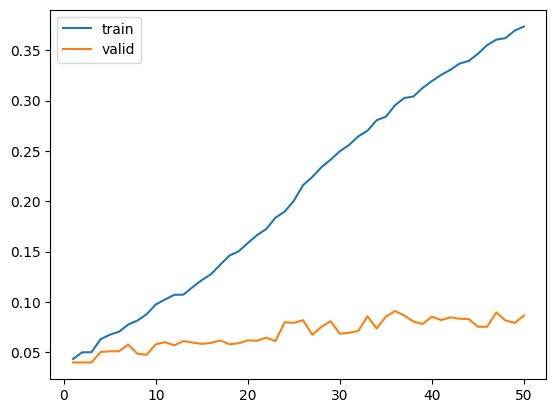

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [49]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [51]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

D:\Users\juanp_schamun\AppData\Local\Temp\ipykernel_2684\182099320.py:24: GradioDeprecationWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 37ms/step
Keyboard interruption in main thread... closing server.


### 6 - Generación de secuencias nuevas

In [52]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [53]:
input_text='hey jude don\'t'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 25ms/step


"hey jude don't time of"

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.